In [2]:
# Делаем загрузку файла интерактивной
from google.colab import files

# Открывается окно для загрузки файла пользователем
uploaded = files.upload()

# Загрузка данных из файла
file_name = list(uploaded.keys())[0]  # Получаем имя загруженного файла
data = pd.read_csv(file_name)

# Просматриваем первые несколько строк данных для ознакомления
data.head()



Saving glass.csv to glass.csv


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


<ipython-input-4-f0d76e3f1280>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")


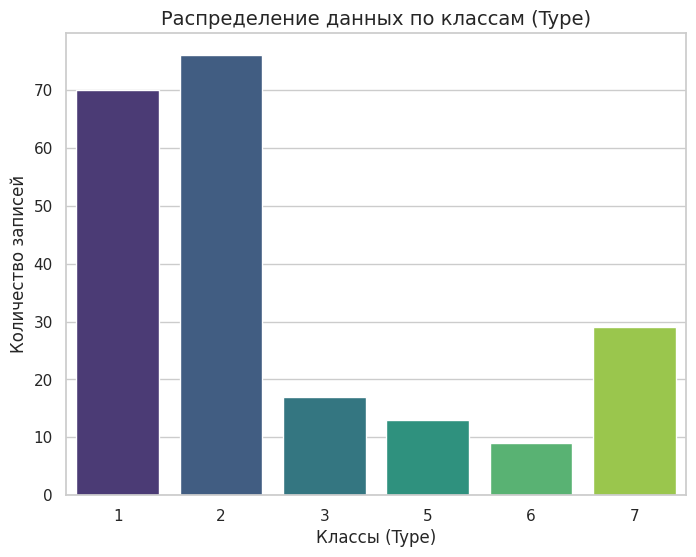

In [4]:
# Проверяем наличие пропусков в данных
missing_values = data.isnull().sum()

# Проверяем количество записей для каждого класса целевой переменной "Type"
class_distribution = data['Type'].value_counts()

# Выводим результаты анализа: наличие пропусков и распределение классов
missing_values, class_distribution

# Импортируем библиотеку для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Настраиваем стиль для графиков
sns.set(style="whitegrid")

# Построение столбчатой диаграммы распределения классов
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title("Распределение данных по классам (Type)", fontsize=14)
plt.xlabel("Классы (Type)", fontsize=12)
plt.ylabel("Количество записей", fontsize=12)
plt.show()


# Выводы
Данные несбалансированы, так как некоторые классы имеют значительно меньшее количество записей, чем другие. Особенно это касается классов 5 и 6, которые представлены небольшим числом записей.


In [5]:
# Импортируем функцию для разделения данных на обучающее и тестовое подмножества
from sklearn.model_selection import train_test_split

# Определим целевую переменную (y) и признаки (X)
X = data.drop(columns='Type')  # Признаки — все столбцы, кроме целевой переменной "Type"
y = data['Type']  # Целевая переменная

# Разделяем данные на обучающую и тестовую выборки: 80% на обучение, 20% на тестирование
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Проверим размеры полученных выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((171, 9), (43, 9), (171,), (43,))

In [6]:
# Импортируем модель RandomForestClassifier и метрику accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Создаем экземпляр модели RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Обучаем модель на обучающих данных
model.fit(X_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Рассчитываем точность предсказания модели
accuracy = accuracy_score(y_test, y_pred)

# Выводим точность модели
accuracy


0.8372093023255814

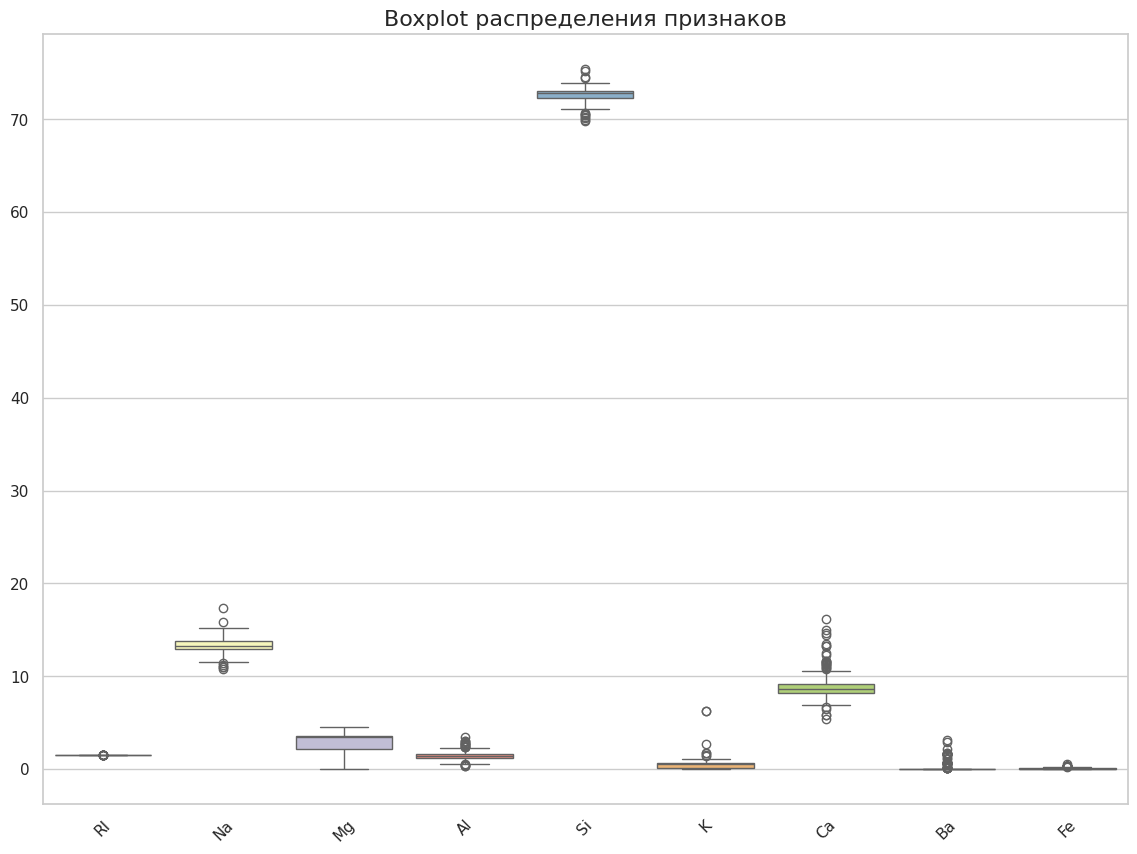

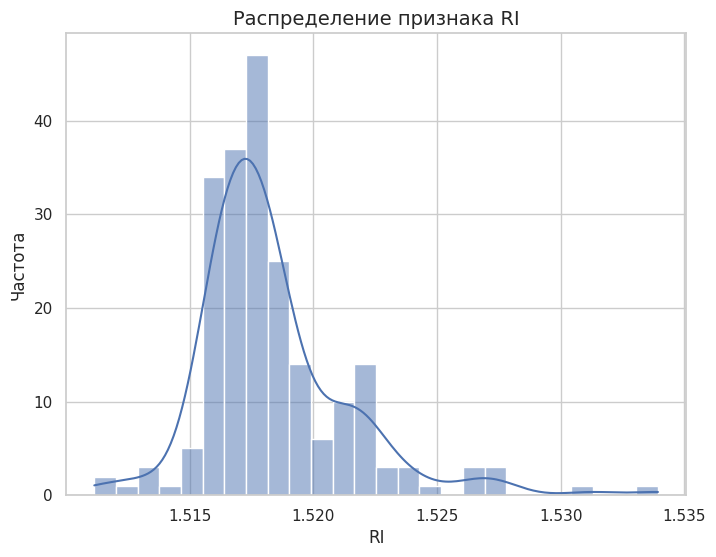

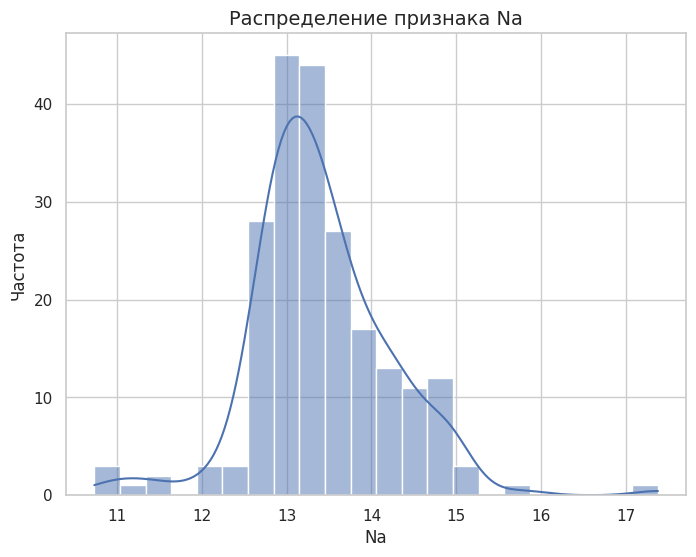

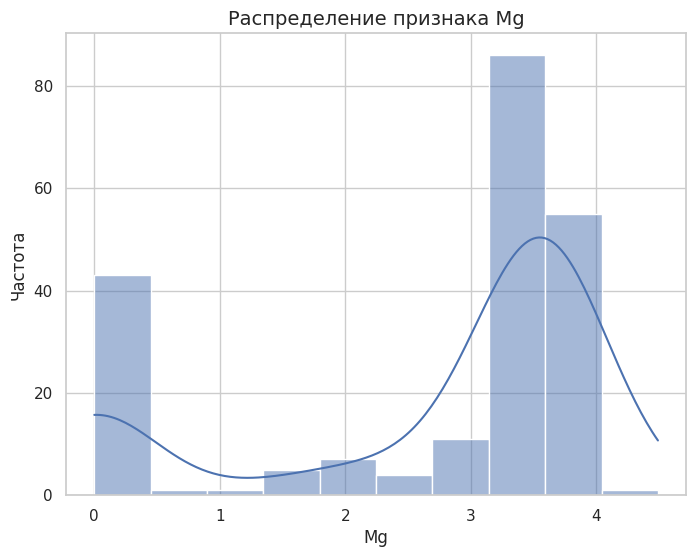

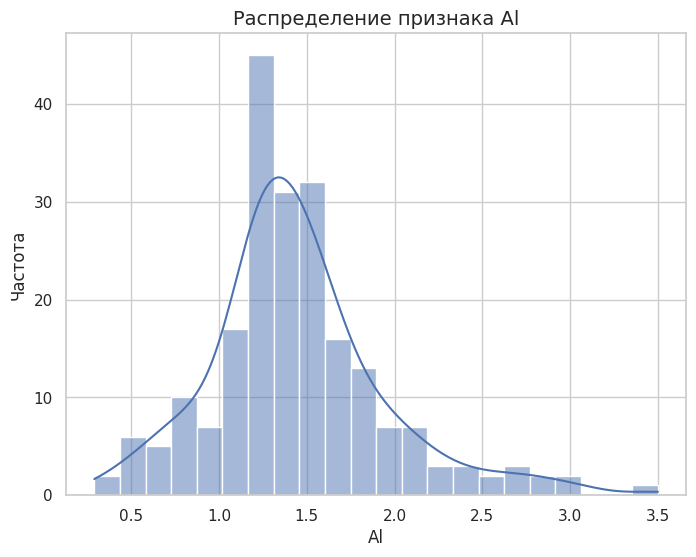

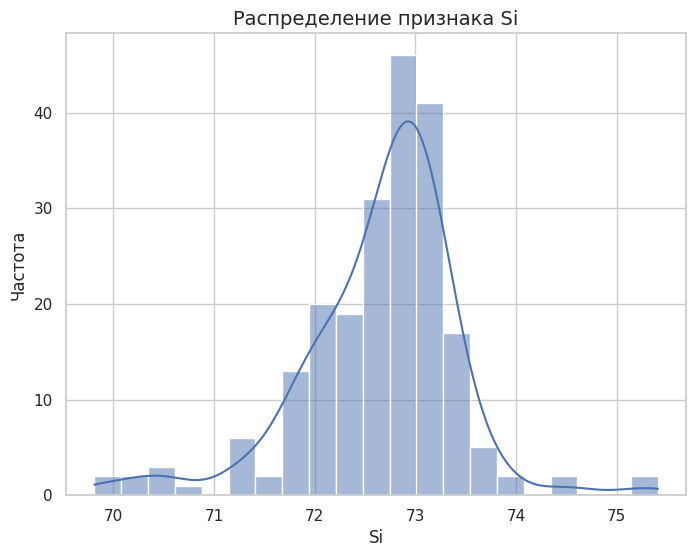

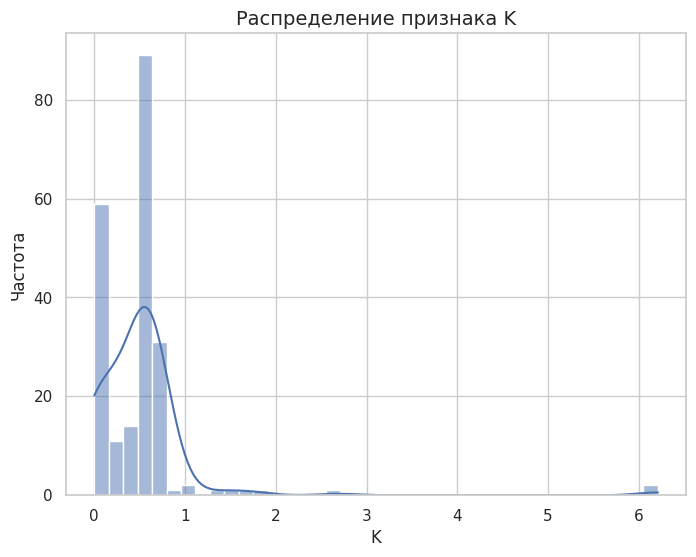

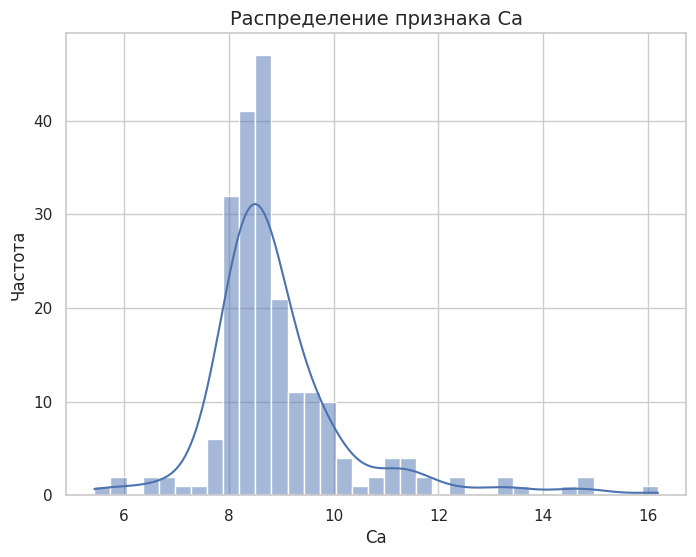

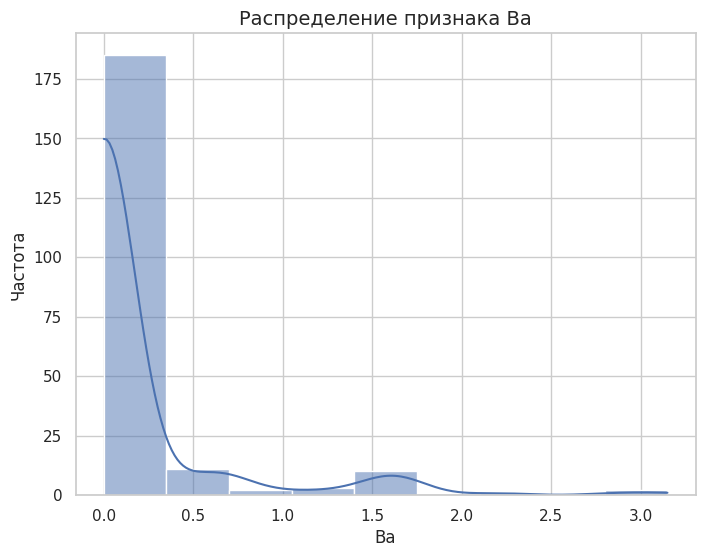

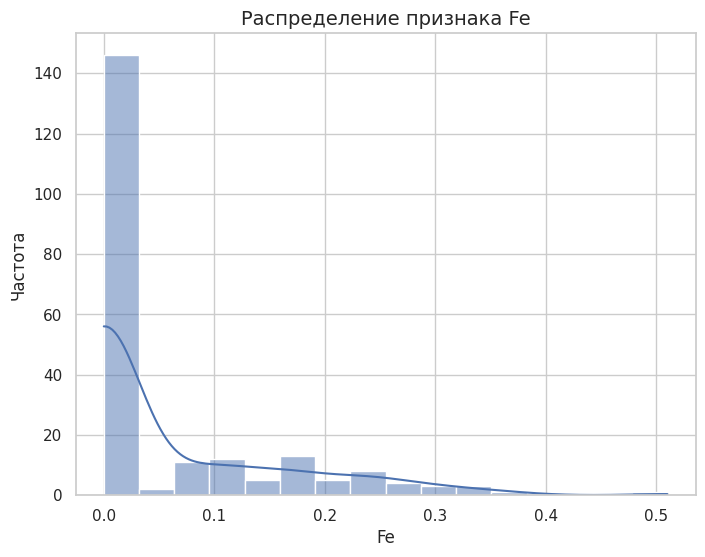

In [7]:
# Визуализация распределения значений для каждой переменной с помощью boxplot и distplot
# Для начала построим boxplot для всех переменных

plt.figure(figsize=(14, 10))
sns.boxplot(data=data.drop(columns='Type'), palette="Set3")
plt.title("Boxplot распределения признаков", fontsize=16)
plt.xticks(rotation=45)
plt.show()

# Построим дистрибуции для каждого признака с помощью distplot
for column in data.drop(columns='Type').columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], kde=True)
    plt.title(f"Распределение признака {column}", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    plt.show()


#Выводы

Boxplot показал потенциальные выбросы по нескольким признакам, особенно для элементов, таких как Ba и Fe, где наблюдаются выбросы

Histograms с кривыми плотности распределения показали, что большинство признаков имеют смещённое распределение, и лишь немногие приближены к нормальному.

#План исследования

Проведем исследование выбросов тремя методами

SVM (Support Vector Machine) для детекции выбросов: использовать метод One-Class SVM.

Isolation Forest: применить Isolation Forest для выявления аномальных значений.

Local Outlier Factor (LOF): использовать LOF для нахождения локальных выбросов.

**Мы проведем детекцию выбросов с помощью каждого из этих методов и отметим выбросы для дальнейшего объединения результатов.**

In [8]:
# Импортируем необходимые методы для детекции выбросов
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Для каждого метода зададим количество аномалий, приблизительно 5% от общего числа данных
contamination = 0.05

# 1. One-Class SVM
svm_clf = OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
svm_clf.fit(X_train)
svm_outliers = svm_clf.predict(X_train)

# 2. Isolation Forest
iso_forest = IsolationForest(contamination=contamination, random_state=42)
iso_forest.fit(X_train)
iso_outliers = iso_forest.predict(X_train)

# 3. Local Outlier Factor (LOF)
lof_clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
lof_outliers = lof_clf.fit_predict(X_train)

# Преобразуем результаты детекции выбросов в бинарный формат (1 - нормальные, -1 - выбросы)
svm_outliers = pd.Series(svm_outliers).map({1: 0, -1: 1})  # 1 - выброс
iso_outliers = pd.Series(iso_outliers).map({1: 0, -1: 1})  # 1 - выброс
lof_outliers = pd.Series(lof_outliers).map({1: 0, -1: 1})  # 1 - выброс

# Добавляем результаты в DataFrame для дальнейшего анализа
outliers_df = pd.DataFrame({
    'SVM': svm_outliers,
    'IsolationForest': iso_outliers,
    'LOF': lof_outliers
})

# Выводим первые несколько строк для просмотра результатов
outliers_df.head()


,SVM,IsolationForest,LOF
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [9]:
# Объединим результаты трех методов для определения окончательных выбросов
# Логика: выбросом считается запись, если все три метода указали, что это выброс (значение 1 для всех методов)

# Создаем финальный столбец, который будет содержать 1, если все три метода классифицировали запись как выброс
outliers_df['Final_Outliers'] = (outliers_df['SVM'] + outliers_df['IsolationForest'] + outliers_df['LOF']) == 3

# Посчитаем количество выбросов, которые все три метода определили как аномальные
final_outliers_count = outliers_df['Final_Outliers'].sum()

# Процент выбросов от общего количества записей
final_outliers_percentage = (final_outliers_count / len(outliers_df)) * 100

# Выводим результаты: количество выбросов и процент от общего числа записей
final_outliers_count, final_outliers_percentage


(1, 0.5847953216374269)

В результате объединения трёх методов (SVM, Isolation Forest и LOF):

Только 1 запись была классифицирована как выброс всеми тремя методами.
Это составляет примерно 0.58% от общего числа записей.

**Это слишком мало, поэтому оставим для радботы только IsolationForest**

In [10]:
# Исправляем несоответствие индексов для фильтрации выбросов по результатам Isolation Forest
# Сначала сбрасываем индексы для X_train и iso_outliers, чтобы индексы совпадали

X_train_reset = X_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)
iso_outliers_reset = iso_outliers.reset_index(drop=True)

# Удаляем записи, которые Isolation Forest классифицировал как выбросы (1 - выброс)
X_train_cleaned = X_train_reset[iso_outliers_reset == 0]
y_train_cleaned = y_train_reset[iso_outliers_reset == 0]

# Рассчитаем количество удаленных записей
removed_records_count = len(X_train) - len(X_train_cleaned)

# Посчитаем процент удаленных записей от общего числа записей для каждого класса
removed_percentage_by_class = (y_train.value_counts() - y_train_cleaned.value_counts()) / y_train.value_counts() * 100

# Выводим результаты: количество удаленных записей и процент по классам
removed_records_count, removed_percentage_by_class


(9,
 Type
 2     6.557377
 1     0.000000
 7     8.695652
 3     0.000000
 5    20.000000
 6    14.285714
 Name: count, dtype: float64)

Результаты удаления выбросов с использованием метода Isolation Forest:

Всего удалено: 9 записей.
Процент удалённых записей для каждого класса:
Класс 2: 6.56%
Класс 1: 0.00%
Класс 7: 8.70%
Класс 3: 0.00%
Класс 5: 20.00%
Класс 6: 14.29%

In [11]:
# Создаем новый экземпляр модели RandomForestClassifier
model_cleaned = RandomForestClassifier(random_state=42)

# Обучаем модель на очищенных данных
model_cleaned.fit(X_train_cleaned, y_train_cleaned)

# Делаем предсказания на тестовой выборке
y_pred_cleaned = model_cleaned.predict(X_test)

# Рассчитываем точность предсказания модели на тестовых данных
accuracy_cleaned = accuracy_score(y_test, y_pred_cleaned)

# Выводим точность модели
accuracy_cleaned


0.7441860465116279

После удаления выбросов точность модели на тестовых данных снизилась до 74.4%.

Попытаемся получить лучший результат используя метод межквартильного размаха

In [12]:
# Функция для удаления выбросов методом межквартильного размаха
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Определяем границы для выявления выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Удаляем записи, которые являются выбросами
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

# Применяем метод IQR для удаления выбросов на обучающих данных
X_train_iqr_cleaned = remove_outliers_iqr(X_train_reset)

# Приведем y_train в соответствие с очищенными X_train
y_train_iqr_cleaned = y_train_reset.loc[X_train_iqr_cleaned.index]

# Рассчитаем количество удаленных записей
removed_records_iqr_count = len(X_train) - len(X_train_iqr_cleaned)

# Посчитаем процент удаленных записей от общего числа записей для каждого класса
removed_percentage_iqr_by_class = (y_train.value_counts() - y_train_iqr_cleaned.value_counts()) / y_train.value_counts() * 100

# Выводим результаты: количество удаленных записей и процент по классам
removed_records_iqr_count, removed_percentage_iqr_by_class


(62,
 Type
 1    14.285714
 2    27.868852
 3    14.285714
 5    90.000000
 6    42.857143
 7          NaN
 Name: count, dtype: float64)

Результаты удаления выбросов с использованием метода межквартильного размаха (IQR):

Всего удалено: 62 записи.

Процент удалённых записей для каждого класса:

Класс 1: 14.29%
Класс 2: 27.87%
Класс 3: 14.29%
Класс 5: 90.00%
Класс 6: 42.86%
Класс 7: нет удалённых записей (NaN, так как все записи класса 7 были в пределах IQR).

In [13]:
# Создаем новый экземпляр модели RandomForestClassifier
model_iqr_cleaned = RandomForestClassifier(random_state=42)

# Обучаем модель на данных, очищенных методом IQR
model_iqr_cleaned.fit(X_train_iqr_cleaned, y_train_iqr_cleaned)

# Делаем предсказания на тестовой выборке
y_pred_iqr_cleaned = model_iqr_cleaned.predict(X_test)

# Рассчитываем точность предсказания модели на тестовых данных
accuracy_iqr_cleaned = accuracy_score(y_test, y_pred_iqr_cleaned)

# Выводим точность модели
accuracy_iqr_cleaned


0.5581395348837209

После удаления выбросов методом межквартильного размаха (IQR) точность модели снизилась до 55.8%.

Очевидно, что удаление большого количества данных, особенно из некоторых классов, негативно сказалось на точности модели.

#Выводы

**а) Преобразования, выполненные с данными:**

Первоначальная модель без обработки выбросов показала точность 83.7%.

Обработка выбросов с помощью метода Isolation Forest: после удаления 9 записей точность модели снизилась до 74.4%.

Обработка выбросов с помощью метода межквартильного размаха (IQR): было удалено 62 записи, что значительно повлияло на модель, снизив точность до 55.8%.

**b) Сравнение точности моделей:**

Без обработки выбросов: 83.7%

После обработки выбросов методом Isolation Forest: 74.4%

После обработки выбросов методом IQR: 55.8%

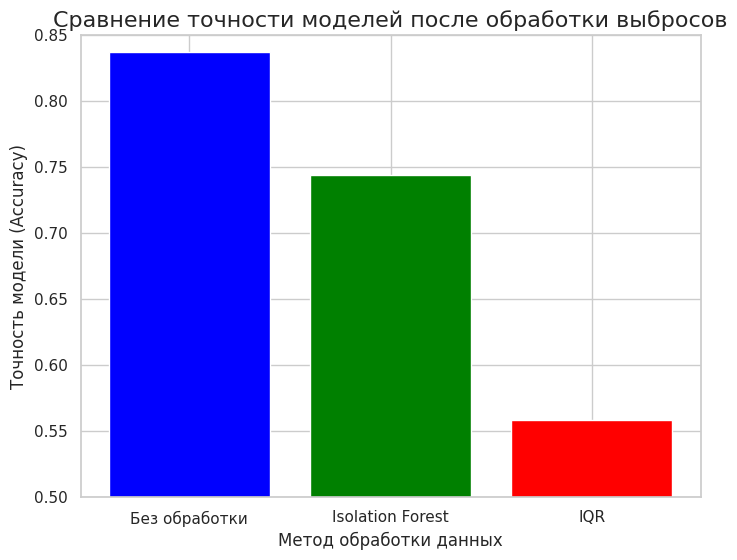

In [14]:
# Импортируем библиотеку для построения диаграмм
import matplotlib.pyplot as plt

# Данные для сравнения точности моделей
model_names = ['Без обработки', 'Isolation Forest', 'IQR']
accuracies = [0.837, 0.744, 0.558]

# Построение диаграммы для сравнения точности моделей
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.title('Сравнение точности моделей после обработки выбросов', fontsize=16)
plt.xlabel('Метод обработки данных', fontsize=12)
plt.ylabel('Точность модели (Accuracy)', fontsize=12)
plt.ylim(0.5, 0.85)  # Устанавливаем диапазон по оси Y для наглядности
plt.show()


#Общий вывод

Мне кажется, что проблема может быть связана не только с выбросами, но и с самим датасетом. Наблюдается явная несбалансированность классов, что особенно видно в меньших классах (например, класс 5, где было удалено 90% данных при использовании метода IQR). Такая диспропорция может отрицательно сказываться на обучении модели, так как меньшие классы получают меньше внимания.

Возможное решение — это работа с несбалансированными классами, например, через методы ресэмплинга (oversampling/undersampling) или использование методов классификации, устойчивых к дисбалансу данных.